In [1]:
#Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [7]:
#Import data into tensorflow dataset object
#We will use image_dataset_from_directory api to load all images in tensorflow dataset:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 542 files belonging to 2 classes.


In [53]:
#Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/VFEOskzhhbc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [8]:
class_names = dataset.class_names
class_names

['miner_img_xml', 'rust_xml_image']

In [9]:
len(dataset)

17

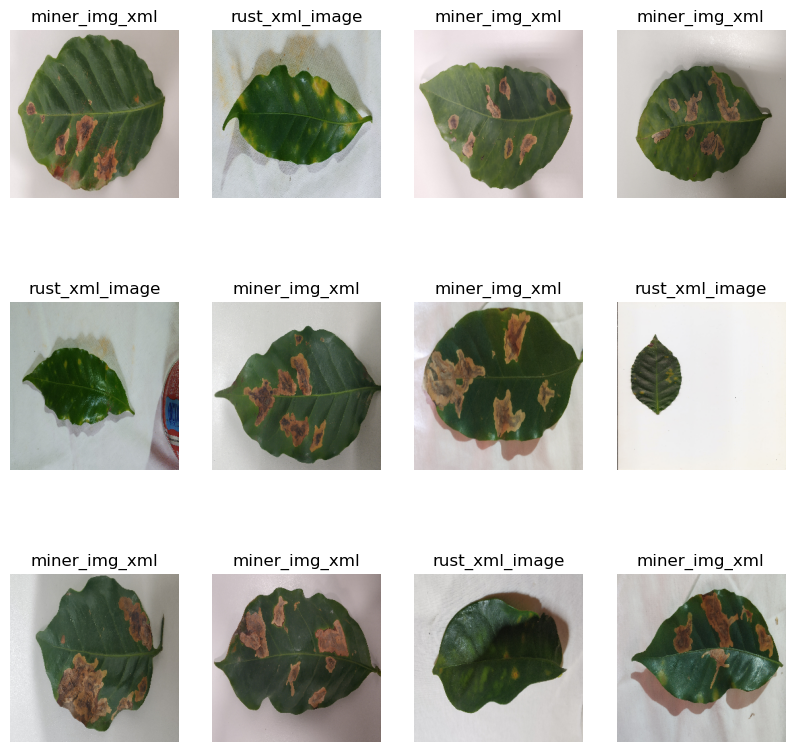

In [18]:
#Visualize some of the images from our dataset

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    
  

In [ ]:
#Function to Split Dataset
#Dataset should be bifurcated into 3 subsets, namely:

#1.)Training: Dataset to be used while training
#2.)Validation: Dataset to be tested against while training
#3.)Test: Dataset to be tested against after we trained a model

In [19]:
len(dataset)

17

In [54]:
# We will use 80% training , 20% ==> 10% validation, 10% test


In [21]:
train_size = 0.8
len(dataset)*train_size


13.600000000000001

In [23]:
train_ds = dataset.take(13)
len(train_ds)

13

In [24]:
test_ds = dataset.skip(13)
len(test_ds)

4

In [25]:
val_size=0.1
len(dataset)*val_size

1.7000000000000002

In [26]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [27]:
test_ds = test_ds.skip(1)
len(test_ds)

3

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8 , val_split = 0.1 , test_split =0.1, shuffle= True , shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds , val_ds , test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [28]:
len(train_ds)

13

In [29]:
len(val_ds)

1

In [30]:
len(test_ds)

3

In [ ]:
#Cache, Shuffle, and Prefetch the Dataset

train_ds = train.ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [32]:
#Building the Model
#Creating a Layer for Resizing and Normalization
#Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
#You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it


resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [33]:
#Data Augmentation
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])



In [56]:
#Watch below video if you are not familiar with data augmentation

HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/mTVf7BN7S8w" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")


In [ ]:
#Model Architecture
#We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, 
#normalization and Data Augmentation.
#We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.
#Watch below video to understand fundamentals of CNN

In [57]:
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/zfiSAzpy9NM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [39]:
#Compiling the Model
#We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
13/13 [==============================] - 161s 10s/step - loss: 0.3641 - accuracy: 0.8341 - val_loss: 0.2685 - val_accuracy: 0.8750
Epoch 2/50
13/13 [==============================] - 106s 6s/step - loss: 0.2822 - accuracy: 0.8750 - val_loss: 0.2615 - val_accuracy: 0.8750
Epoch 3/50
13/13 [==============================] - 144s 9s/step - loss: 0.1985 - accuracy: 0.9303 - val_loss: 0.2245 - val_accuracy: 0.9062
Epoch 4/50
13/13 [==============================] - 163s 10s/step - loss: 0.2093 - accuracy: 0.9111 - val_loss: 0.2716 - val_accuracy: 0.9062
Epoch 5/50
13/13 [==============================] - 167s 10s/step - loss: 0.1945 - accuracy: 0.9183 - val_loss: 0.1104 - val_accuracy: 0.9375
Epoch 6/50
13/13 [==============================] - 153s 10s/step - loss: 0.1225 - accuracy: 0.9471 - val_loss: 0.0427 - val_accuracy: 1.0000
Epoch 7/50
13/13 [==============================] - 159s 10s/step - loss: 0.1166 - accuracy: 0.9519 - val_loss: 0.0250 - val_accuracy: 1.0000
Epoch 8/

In [42]:
scores = model.evaluate(test_ds)

#You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

3/3 [==============================] - 41s 591ms/step - loss: 2.3481e-04 - accuracy: 1.0000


In [43]:
scores

#Scores is just a list containing loss and accuracy value

[0.00023480795789510012, 1.0]

In [44]:
history
#You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [45]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 13}

In [46]:
history.history.keys()

#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

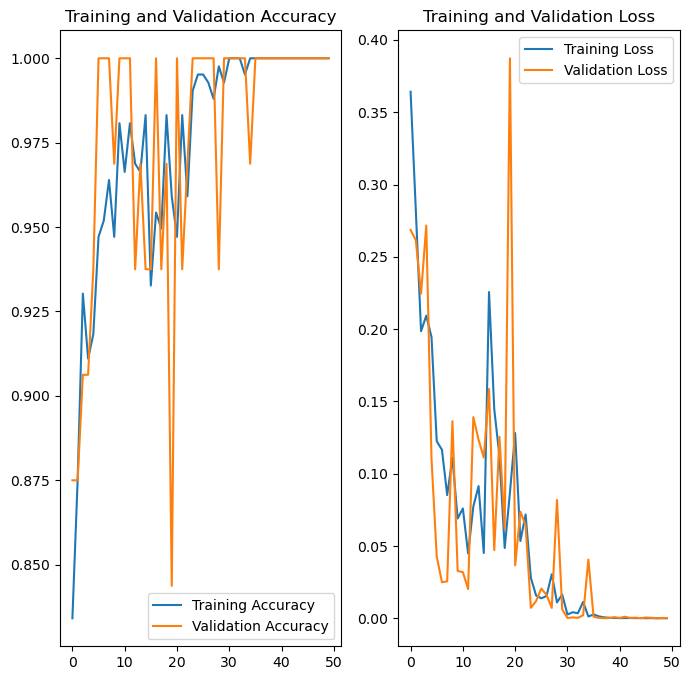

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: miner_img_xml
1/1 [==============================] - 15s 15s/step
predicted label: miner_img_xml


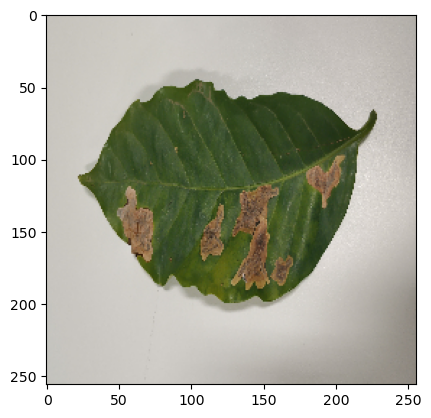

In [50]:
#Run prediction on a sample image


import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [51]:
#Write a function for inference


def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 11s 11s/step


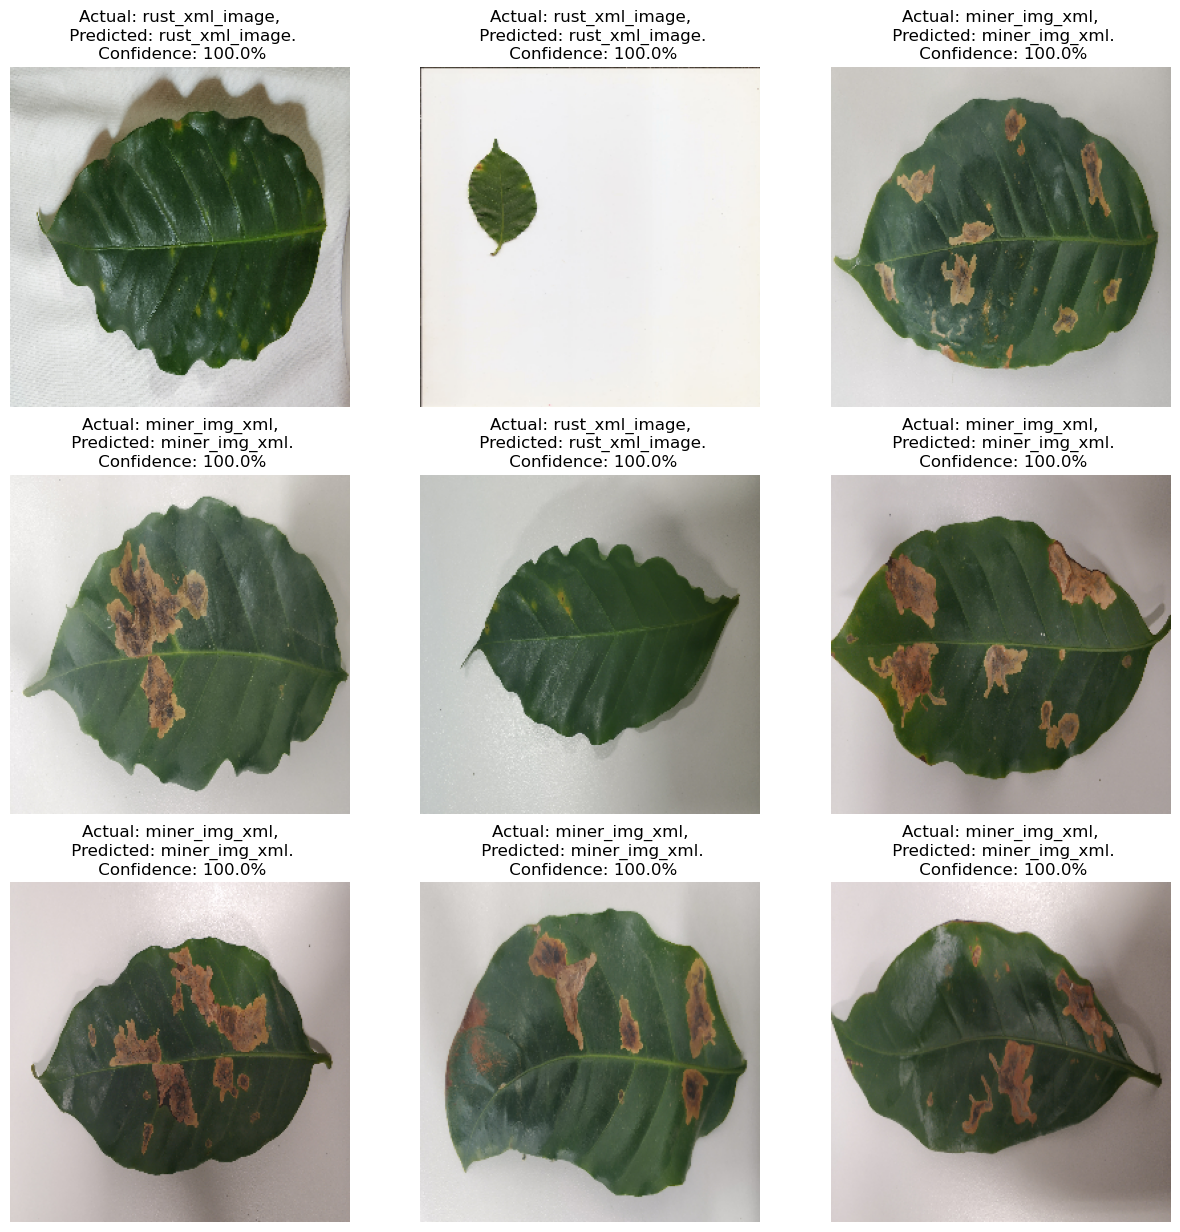

In [52]:
#Now run inference on few sample images

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [59]:
#Saving the Model
#We append the model to the list of models as a new version

import os
directory = "C:/Users/MARK3/Downloads/Coffee Diseases"
if not os.path.exists(directory):
    os.makedirs(directory)
model.save(directory + "/model.h5")
model.save("C:/Users/MARK3/Downloads/Coffee Diseases/model.h5")
